In [ ]:
# SELECT DISTINCT ?image ?date ?car ?carLabel ?brandLabel 
# WHERE {
#   ?car wdt:P31 wd:Q850270;     
#        wdt:P18 ?image;      
#        wdt:P571 ?date;
#        wdt:P176 ?brand;     
#        rdfs:label ?carLabel.
  
#   ?brand rdfs:label ?brandLabel.
  
#   FILTER(LANG(?carLabel) = "fr" && LANG(?brandLabel) = "fr")
# }

# Collecte de données & Étiquetage et annotation

In [ ]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
import json
from SPARQLWrapper import SPARQLWrapper, JSON
import os
import requests

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT DISTINCT ?image ?date ?car ?carLabel ?brandLabel 
WHERE {
  ?car wdt:P31 wd:Q850270;     
       wdt:P18 ?image;      
       wdt:P571 ?date;
       wdt:P176 ?brand;     
       rdfs:label ?carLabel.
  
  ?brand rdfs:label ?brandLabel.
  
  FILTER(LANG(?carLabel) = "fr" && LANG(?brandLabel) = "fr")
}
LIMIT 150
"""

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

results = get_results(endpoint_url, query)

conceptcars = []

for result in results["results"]["bindings"]:
    conceptcars.append({
        "image": result["image"]["value"],
        "date": result["date"]["value"],
        "car": result["car"]["value"],
        "carLabel": result["carLabel"]["value"],
        "brandLabel": result["brandLabel"]["value"]
    })

for conceptcar in conceptcars:
    conceptcar["carLabel"] = conceptcar["carLabel"].replace("\\", "")
    conceptcar["carLabel"] = conceptcar["carLabel"].replace("/", "")
                                              
with open('conceptcars.json', 'w', encoding='utf-8') as f:
    json.dump(conceptcars, f, ensure_ascii=False, indent=4)


In [27]:
for filename in os.listdir("images"):
    os.remove(f"images/{filename}")
    
with open('conceptcars.json', 'r', encoding='utf-8') as f:
    conceptcars = json.load(f)

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
}

n = 0

for car in conceptcars:
    image_url = car["image"]
    n = n + 1
    r = requests.get(image_url, allow_redirects=True, headers=headers)
    image_url = r.url  

    car_name = car.get("carLabel", "Image n°" + str(n))
    
    image_data = r.content 
    with open(f'images/{car_name}.jpg', 'wb') as f:
        f.write(image_data)

In [ ]:
import os
import json
from PIL import Image as PILImage
from PIL.ExifTags import TAGS
import numpy as np
from sklearn.cluster import KMeans
import ipywidgets as widgets
from ipywidgets import GridspecLayout
from IPython.display import display

title = widgets.HTML("<h2 style='text-align: center;'>Tag selection</h2>")
images_dir = "images"
metadata_dir = "metadata"
os.makedirs(metadata_dir, exist_ok=True)

images = [os.path.join(images_dir, f) for f in os.listdir(images_dir) 
          if f.lower().endswith((".jpg", ".jpeg", ".png"))]

if not images:
    print("Aucune image trouvée dans le dossier.")
else:
    layout = GridspecLayout(len(images), 4, width="800px", grid_gap="5px")
    checkboxes = []

    for i, img_path in enumerate(images):
        with open(img_path, "rb") as img_file:
            img_data = img_file.read()
        img_widget = widgets.Image(value=img_data, format="jpg", width=150, height=150)

        with PILImage.open(img_path) as img:
            metadata = {
                "format": img.format,
                "size": img.size,
                "mode": img.mode,
                "orientation": "Landscape" if img.width > img.height else "Portrait" if img.height > img.width else "Square",
                "camera_model": None,  
                "date_taken": None,  
                "colors": None,  
            }

            exif_data = img._getexif()
            if exif_data:
                exif_info = {TAGS.get(tag, tag): value for tag, value in exif_data.items()}
                metadata["camera_model"] = exif_info.get("Model", None)  
                metadata["date_taken"] = exif_info.get("DateTimeOriginal", None) 

            try:
                img_data = np.array(img.convert("RGB").getdata()) 
                kmeans = KMeans(n_clusters=4, random_state=0).fit(img_data)  
                colors = kmeans.cluster_centers_.astype(int).tolist() 
                metadata["colors"] = colors  
            except Exception as e:
                print(f"Erreur lors de l'extraction des couleurs pour {os.path.basename(img_path)}: {e}")
                metadata["colors"] = None 

        vintage_box = widgets.Checkbox(value=False, description="")
        original_box = widgets.Checkbox(value=False, description="")
        night_box = widgets.Checkbox(value=False, description="")
        label_style = {'font_size': '8px', 'min_width': '70px'}
        vintage = widgets.HBox([vintage_box, widgets.Label("Vintage", layout=widgets.Layout(**label_style))], layout=widgets.Layout(justify_content="center", padding="0 2px"))
        original = widgets.HBox([original_box, widgets.Label("Original", layout=widgets.Layout(**label_style))], layout=widgets.Layout(justify_content="center", padding="0 2px"))
        night = widgets.HBox([night_box, widgets.Label("Night Photo", layout=widgets.Layout(**label_style))], layout=widgets.Layout(justify_content="center", padding="0 2px"))

        layout[i, 0] = img_widget
        layout[i, 1] = vintage
        layout[i, 2] = original
        layout[i, 3] = night
        checkboxes.append((img_path, vintage_box, original_box, night_box, metadata))

    button = widgets.Button(description="Sauvegarder les Tags", button_style="primary", layout=widgets.Layout(margin="10px auto", width="200px", display="flex", justify_content="center"))
    output = widgets.Output()

    def save_tags(btn):
        with output:
            output.clear_output()
            for img_path, vintage_box, original_box, night_box, metadata in checkboxes:
                json_filename = os.path.splitext(os.path.basename(img_path))[0] + ".json"
                json_path = os.path.join(metadata_dir, json_filename)

                tags = []
                if vintage_box.value:
                    tags.append("isVintage")
                if original_box.value:
                    tags.append("isOriginal")
                if night_box.value:
                    tags.append("isNightPicture")

                metadata["tags"] = list(set(metadata.get("tags", []) + tags))
                with open(json_path, "w", encoding="utf-8") as f:
                    json.dump(metadata, f, indent=4, ensure_ascii=False)

                print(f"Tags sauvegardés pour {os.path.basename(img_path)}: {tags}")

    button.on_click(save_tags)

    display(widgets.VBox([title, layout, button, output], 
                        layout=widgets.Layout(align_items="center")))


# Analyses de données

In [37]:
import os
import json
import random
from collections import Counter
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import random

def get_user_image_selection(num_images=3):
    available_images = os.listdir(images_dir)
    selected_images = random.sample(available_images, min(num_images, len(available_images)))
    
    image_tags = {}
    for img in selected_images:
        tags = random.sample(["isVintage", "isOriginal", "isNightPicture"], 2)
        image_tags[img] = tags
    
    return image_tags

def build_user_profile(selected_images):
    profile = {
        "preferred_colors": [],
        "preferred_orientation": [],
        "preferred_sizes": [],
        "favorite_tags": []
    }
    
    for img in selected_images:
        metadata_path = os.path.join(metadata_dir, f"{img.split('.')[0]}.json")
        if os.path.exists(metadata_path):
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
                
            profile["preferred_colors"].extend(metadata["colors"])
            profile["preferred_orientation"].append(metadata["orientation"])

            width, height = metadata["size"]
            size_category = "thumbnail" if width < 500 else "medium" if width < 1000 else "large"
            profile["preferred_sizes"].append(size_category)
            
            profile["favorite_tags"].extend(selected_images[img])
    
    profile["preferred_colors"] = np.mean(profile["preferred_colors"], axis=0).tolist()
    profile["preferred_orientation"] = Counter(profile["preferred_orientation"]).most_common(1)[0][0]
    profile["preferred_sizes"] = Counter(profile["preferred_sizes"]).most_common(1)[0][0]
    profile["favorite_tags"] = list(set(profile["favorite_tags"]))[:3] 
    
    return profile

def enhance_image_data(metadata):
    colors = np.array(metadata["colors"])
    if len(colors) >= 3:  
        kmeans = KMeans(n_clusters=2, random_state=42).fit(colors)
        metadata["color_clusters"] = kmeans.labels_.tolist()
    
    color_variance = np.var(colors, axis=0).mean()
    metadata["color_complexity"] = float(color_variance)
    
    return metadata

def create_random_users(num_users=5):
    users = {}
    for i in range(num_users):
        user_id = f"user_{i+1}"
        selected_images = get_user_image_selection()
        profile = build_user_profile(selected_images)
        users[user_id] = {
            "selected_images": selected_images,
            "profile": profile
        }
    
    return users

def analyze_users(users):
    all_colors = []
    all_sizes = []
    all_tags = []
    
    for user_id, data in users.items():
        all_colors.append(data["profile"]["preferred_colors"])
        all_sizes.append(data["profile"]["preferred_sizes"])
        all_tags.extend(data["profile"]["favorite_tags"])
    
    avg_color = np.mean(all_colors, axis=0)
    most_common_size = Counter(all_sizes).most_common(1)[0][0]
    top_tags = [tag for tag, count in Counter(all_tags).most_common(3)]
    
    return {
        "average_preferred_color": avg_color.tolist(),
        "most_common_size": most_common_size,
        "top_tags": top_tags
    }

users = create_random_users(5)
print("Utilisateurs créés :", len(users))
print("\nExemple de profil utilisateur :")
print(json.dumps(users["user_1"], indent=2))
analysis = analyze_users(users)
print("\nAnalyse globale :")
print(json.dumps(analysis, indent=2))

Utilisateurs créés : 5

Exemple de profil utilisateur :
{
  "selected_images": {
    "Lancia Florida.jpg": [
      "isNightPicture",
      "isVintage"
    ],
    "Lamborghini Cal\u00e0.jpg": [
      "isNightPicture",
      "isVintage"
    ],
    "C-Sportlounge.jpg": [
      "isNightPicture",
      "isOriginal"
    ]
  },
  "profile": {
    "preferred_colors": [
      125.33333333333333,
      109.0,
      79.58333333333333
    ],
    "preferred_orientation": "Landscape",
    "preferred_sizes": "large",
    "favorite_tags": [
      "isVintage",
      "isNightPicture",
      "isOriginal"
    ]
  }
}

Analyse globale :
{
  "average_preferred_color": [
    118.21666666666665,
    114.98333333333335,
    107.38333333333333
  ],
  "most_common_size": "large",
  "top_tags": [
    "isVintage",
    "isNightPicture",
    "isOriginal"
  ]
}


- Création des utilisateurs aléatoires : J’ai simulé 5 utilisateurs avec des sélections d’images aléatoires du dossier /images et des tags générés aléatoirement.
- Nombre d’utilisateurs : 5.
- Informations stockées : Pour chaque utilisateur, les images sélectionnées (avec tags) et un profil (couleurs préférées, orientation, tailles, tags favoris).
- Analyses effectuées : Couleur moyenne préférée, taille d’image la plus courante, top tags globaux via des statistiques (moyennes, fréquences).

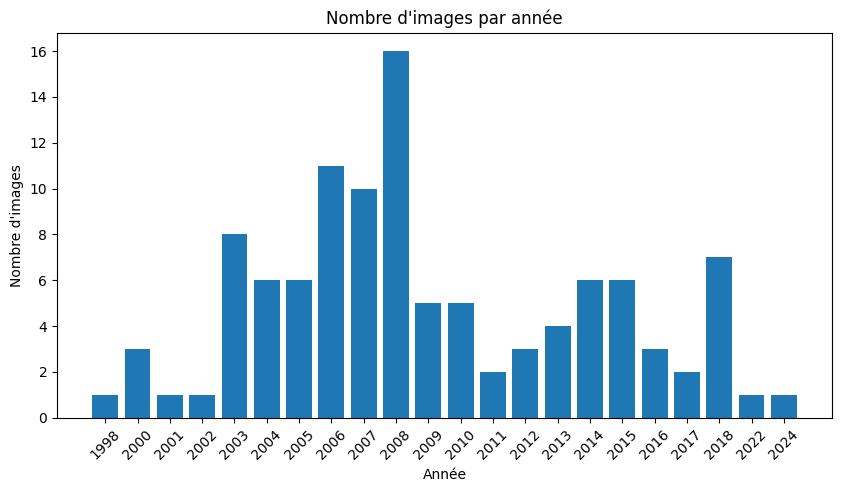

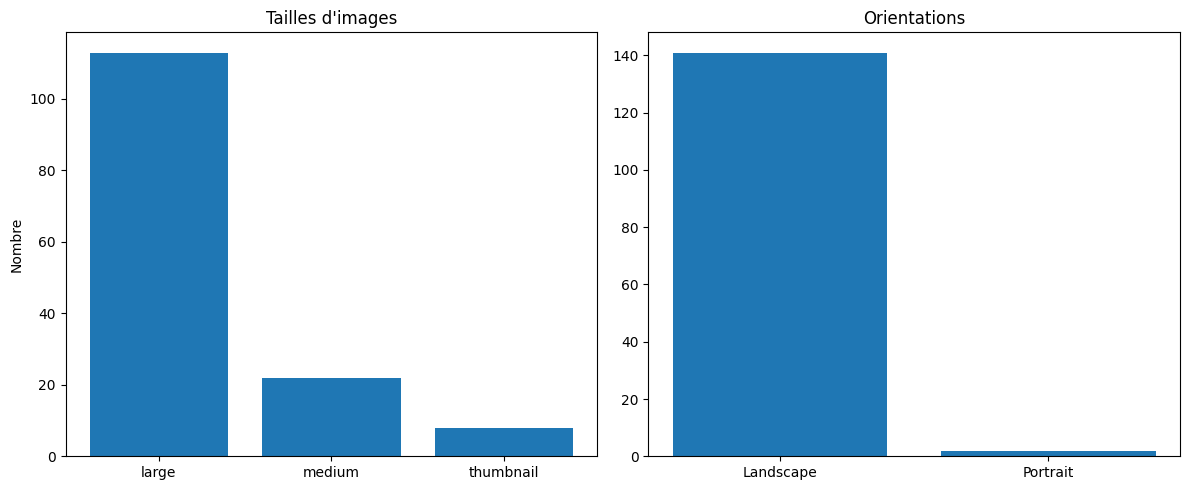

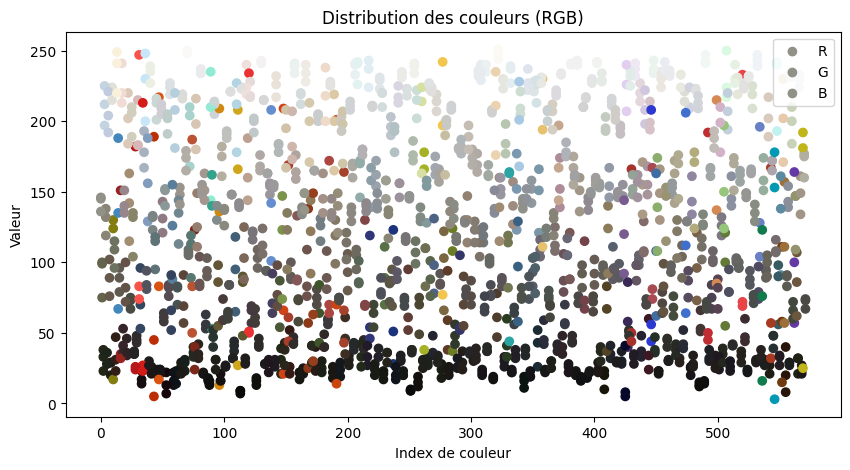

In [38]:
def load_all_metadata():
    metadata_list = []
    for file in os.listdir(metadata_dir):
        if file.endswith(".json"):
            with open(os.path.join(metadata_dir, file), 'r') as f:
                metadata_list.append(json.load(f))
    return metadata_list

# Simuler la création d'utilisateurs
def create_random_users(num_users=1):
    all_images = [f.split('.')[0] for f in os.listdir("images") if f.endswith(('.jpg', '.png', '.jpeg'))]
    users = {}
    for i in range(num_users):
        user_id = f"user_{i+1}"
        selected_images = {img: random.sample(["nature", "portrait"], 2) for img in random.sample(all_images, min(2, len(all_images)))}
        profile = {
            "preferred_colors": [random.randint(0, 255) for _ in range(3)],
            "preferred_orientation": "Landscape",
            "preferred_sizes": "medium",
            "favorite_tags": ["nature", "portrait"]
        }
        users[user_id] = {"selected_images": selected_images, "profile": profile}
    return users

# 1. Images par année
def plot_images_by_year(metadata_list):
    years = [m["date_taken"].split(":")[0] for m in metadata_list 
             if "date_taken" in m and m["date_taken"] is not None and m["date_taken"].split(":")[0] != "0000"]
    if not years:
        print("Aucune donnée d'année valide disponible.")
        return
    
    year_counts = Counter(years)
    
    plt.figure(figsize=(10, 5))
    plt.bar(sorted(year_counts.keys()), [year_counts[year] for year in sorted(year_counts.keys())])
    plt.title("Nombre d'images par année")
    plt.xlabel("Année")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45)
    plt.show()

# 2. Types d'images
def plot_image_types(metadata_list):
    sizes = ["thumbnail" if m["size"][0] < 500 else "medium" if m["size"][0] < 1000 else "large" 
             for m in metadata_list]
    size_counts = Counter(sizes)
    
    orientations = [m["orientation"] for m in metadata_list 
                    if "orientation" in m and m["orientation"] is not None]
    orientation_counts = Counter(orientations)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.bar(size_counts.keys(), size_counts.values())
    ax1.set_title("Tailles d'images")
    ax1.set_ylabel("Nombre")
    
    ax2.bar(orientation_counts.keys(), orientation_counts.values())
    ax2.set_title("Orientations")
    
    plt.tight_layout()
    plt.show()

# 3. Caractéristiques des couleurs
def plot_color_characteristics(metadata_list):
    all_colors = [color for m in metadata_list for color in m["colors"] if color]
    if not all_colors:
        print("Aucune donnée de couleur disponible.")
        return
    colors_array = np.array(all_colors)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(colors_array)), colors_array[:, 0], c=colors_array/255, label="R")
    plt.scatter(range(len(colors_array)), colors_array[:, 1], c=colors_array/255, label="G")
    plt.scatter(range(len(colors_array)), colors_array[:, 2], c=colors_array/255, label="B")
    plt.title("Distribution des couleurs (RGB)")
    plt.xlabel("Index de couleur")
    plt.ylabel("Valeur")
    plt.legend()
    plt.show()


all_metadata = load_all_metadata()
plot_images_by_year(all_metadata)
plot_image_types(all_metadata)
plot_color_characteristics(all_metadata)